In [1]:
from pathinit import *



import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
#from jax.ops import index, index_update
jax.config.update("jax_enable_x64", True)

from functools import partial


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18

2022-04-25 09:49:46.415047: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-04-25 09:49:46.545799: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-04-25 09:49:46.552553: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 


## Attention: Il y a (au moins) 2 pratiques en vigueur: 
- soit (numpy -> np, jax.numpy -> jnp) 
- soit (numpy -> onp, jax.numpy -> np)

# Example de l'usage de l'auto-diff et la vectorisation

In [4]:
def f(x):
    return jnp.exp(-x*0.5)*jnp.sin(x)

In [5]:
# Expressions Exactes de f'(x) et f''(x)
def fp(x):
    return jnp.exp(-x*0.5)*(2.*jnp.cos(x)-jnp.sin(x))/2.
def fpp(x):
    return -jnp.exp(-x*0.5)*(4.*jnp.cos(x)+3.*jnp.sin(x))/4.

# Expressions numériques centrées approchées de f'(x) et f''(x)
def fpnum(x,h=0.1):
    return (f(x+h)-f(x-h))/(2*h)
def fppnum(x,h=0.1):
    return (f(x+h)-2*f(x)+f(x-h))/h**2

# Différéntiations successives

In [6]:
jfp  = grad(f)             # grad pour gradient
jfpp = grad(grad(f))

## Voir que fait JAX quand il produit le code...

In [7]:
jax.make_jaxpr(jfp)(0.)

{ lambda ; a:f64[]. let
    b:f64[] = neg a
    c:f64[] = mul b 0.5
    d:f64[] = exp c
    e:f64[] = sin a
    f:f64[] = cos a
    _:f64[] = mul d e
    g:f64[] = mul d 1.0
    h:f64[] = mul 1.0 e
    i:f64[] = mul g f
    j:f64[] = mul h d
    k:f64[] = mul j 0.5
    l:f64[] = neg k
    m:f64[] = add_any i l
  in (m,) }

### prenez un papier et un crayon et vérifier que ce code est correcte :) 

## La vectorisation est utile pour appeler la fonction avec un array (nb. et d'autres structures)

In [8]:
jfp  = vmap(grad(f))
jfpp = vmap(grad(grad(f)))
#jfjacobien = vmap(jacfwd(f))
#jfhessien  = vmap(hessian(f))

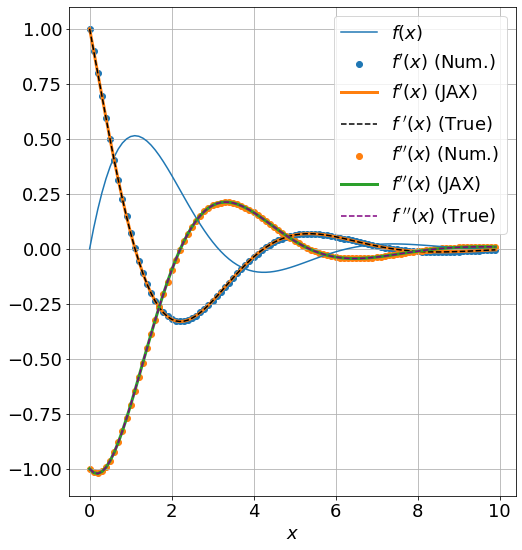

In [9]:
fig,_ = plt.subplots(figsize=(8,9))
x=jnp.arange(0,10,0.1)
plt.plot(x,f(x), label="$f(x)$")
plt.scatter(x,fpnum(x), label="$f^{\prime}(x)$ (Num.)")
plt.plot(x,jfp(x), lw=3,label="$f^{\prime}(x)$ (JAX)")
plt.plot(x,fp(x),ls="--",c='k', label="$f^{\ \prime}(x)$ (True)")
#plt.plot(x,jfjacobien(x),ls='-.', lw=3, label='jacobien')
plt.scatter(x,fppnum(x), label="$f^{\prime\prime}(x)$ (Num.)")
plt.plot(x,jfpp(x), lw=3,label="$f^{\prime\prime}(x)$ (JAX)")
plt.plot(x,fpp(x),ls="--", c='purple',label="$f^{\ \prime\prime}(x)$ (True)")
#plt.plot(x,jfhessien(x), ls='-.', lw=3, label='hessian')
plt.grid()
plt.xlabel("$x$")
plt.legend(loc="upper right");

### Zoom: => Q: à quoi sert l'auto-différentiation? 

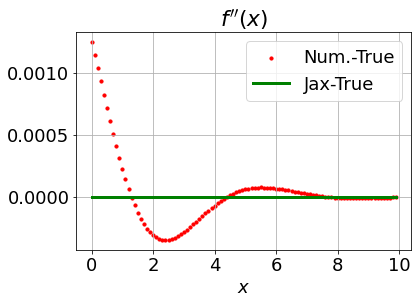

In [78]:
x=jnp.arange(0,10,0.1)
plt.scatter(x,fppnum(x)-fpp(x),s=10, c="r", label="Num.-True")
plt.plot(x,jfpp(x)-fpp(x),lw=3,c="g",  label="Jax-True")
plt.grid()
plt.xlabel("$x$")
plt.title("$f^{\prime\prime}(x)$")
plt.legend(loc="upper right");

In [79]:
x=jnp.arange(0,10,0.1)
jnp.max(jnp.abs(jfpp(x)-fpp(x)))

DeviceArray(2.22044605e-16, dtype=float64)

vous pouvez essayer d'utiliser le *jacobien* et le *hessien* ...

## La différentiation est par défaut sur le 1er argument de la fonction mais cela n'est pas exclusif

In [16]:
def func(x, y):
    return 2 * x * y

print(grad(func)(3., 4.))  # 8.                 # la fonction evaluee en (3,4)
print(grad(func, argnums=0)(3., 4.))  # 8.      # la derivee par rapport a x evaluee en (3,4)
print(grad(func, argnums=1)(3., 4.))  # 6       # la derivee par rapport a ye valuee en (3,4)
print(grad(func, argnums=(0, 1))(3., 4.))  # (8., 6.)  # ici on fait en mm temps la derivée par rapport a x et a y...

8.0
8.0
6.0
(DeviceArray(8., dtype=float64, weak_type=True), DeviceArray(6., dtype=float64, weak_type=True))


In [17]:
grad(func)(3., 4.)

DeviceArray(8., dtype=float64, weak_type=True)

essayer avec une autre fonction...

# Exemple via la minimisation de la Mean Squared Error (MSE)

In [24]:
def model(p, x):
    return jnp.exp(-x*p[0])*jnp.sin(x*p[1])

def loss_fun(p, xi, yi):
    yhat = model(p, xi)
    return jnp.mean( (yhat - yi)**2 )

jnp.exp, jnp.sin ... sont vectorisees donc `model` et `loss_fun` n'ont pas besoin d'un vmap


In [25]:
# dataset
ptrue = jnp.array([0.5,1])

xin = jnp.arange(0,10,1.)
yerr = 0.05
# jax.random.PRNGKey(seed) gestion des randoms numbers
y_true =  model(ptrue, xin)
yin = y_true + yerr*jax.random.normal(jax.random.PRNGKey(42),shape=xin.shape)

In [26]:
xin

DeviceArray([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float64)

on peut directement utiliser les DeviceArray de JAX dans matplotlib

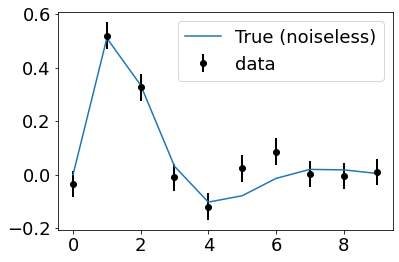

In [29]:
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data");
plt.plot(xin,y_true, label='True (noiseless)')
plt.legend();

## Descente de Gradient

In [43]:
@jit
def gradient_descent_step(p, xi, yi, lr=0.1):
    return p - lr * jax.grad(loss_fun)(p, xi, yi)

nb. nous verrons le pourquoi du `@jit` un peu plus loin

In [44]:
# Un minizer basique (version plus JAX/LAX-like à la fin)
def minimzer(loss_fun, x_data, y_data, par_init, method, verbose=True):
    p_cur = par_init
    new_loss=jnp.inf
    
    for t in range(5000):
   
        if (t % 100 == 0) and verbose:
            print(t, p_cur,new_loss)

        old_loss = new_loss
        new_p = method(p_cur, x_data,y_data)
        new_loss = loss_fun(new_p, x_data,y_data)

        if jnp.abs(new_loss-old_loss) < 1e-9:
            print(f"Converged after {t} epochs: p = {new_p}, loss = {new_loss}")
            break

        p_cur = new_p

    return p_cur

In [45]:
par_mini_GD = minimzer(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=gradient_descent_step, verbose=True)

0 [0.  0.5] inf
100 [0.62048393 0.70750834] 0.008637562559042187
200 [0.59232543 0.93250246] 0.003369178419368657
300 [0.54957041 1.04688945] 0.0017975857523135552
400 [0.53074669 1.08778781] 0.0015735323299857114
500 [0.52542832 1.09953584] 0.0015546792362664712
600 [0.52410865 1.10263342] 0.001553384289830772
Converged after 633 epochs: p = [0.52394625 1.10302972], loss = 0.0015533297417048115


## Recommencez en decommentant "@jit" dans la celleule du `gradient_descent_step` : qu'observe-t'on?

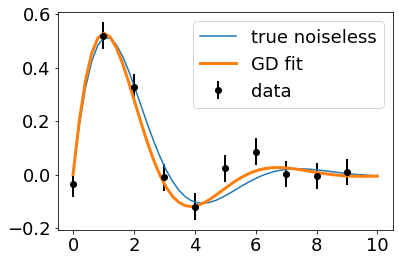

In [46]:
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data")
x_val = jnp.linspace(0.,10,50)
plt.plot(x_val,model(ptrue, x_val),label="true noiseless")
plt.plot(x_val,model(par_mini_GD, x_val) ,lw=3,label="GD fit")
plt.legend();

## Méthod  de Newton => usage du hessien (cf. méthode d'ordre 2, alors que GD : méthode d'ordre 1)

In [51]:
gLoss = lambda p,xi,yi: jacfwd(loss_fun)(p,xi,yi)
hLoss = lambda p,xi,yi: jax.hessian(loss_fun)(p,xi,yi)

@jit
def oneStepNewton(p,xi,yi,lr=0.1):
    return p - lr*jnp.linalg.inv(hLoss(p,xi,yi)) @ gLoss(p,xi,yi)

In [52]:
par_mini_Newton = minimzer(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=oneStepNewton, verbose=True)

0 [0.  0.5] inf
100 [0.07535076 0.00358029] 0.03937574340496317
Converged after 183 epochs: p = [0.52373613 1.10348083], loss = 0.0015532978650187018


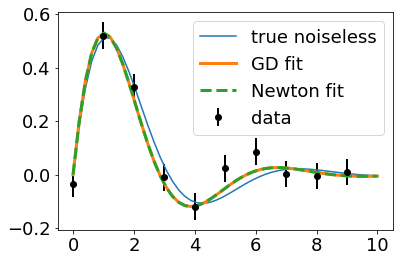

In [53]:
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data")
x_val = jnp.linspace(0.,10,50)
plt.plot(x_val,model(ptrue, x_val),label="true noiseless")
plt.plot(x_val,model(par_mini_GD, x_val) ,lw=3,label="GD fit")
plt.plot(x_val,model(par_mini_Newton, x_val),ls='--',lw=3,label="Newton fit")
plt.legend();

# Gradient/Vmap... par rapport à: tuples, lists, and dicts

In [54]:
def f(p,x):
    return p["a"]**2 + p["b"]*x

## Vectorization partielle: `in-axes`

In [60]:
print(grad(f)({"a":3.,"b":1.},10.))

{'a': DeviceArray(6., dtype=float64, weak_type=True), 'b': DeviceArray(10., dtype=float64, weak_type=True)}


In [61]:
print(grad(f, argnums=1)({"a":3.,"b":1.},10.))

1.0


In [63]:
print(vmap(f, in_axes=({"a": None, "b": 0},None))({"a":1.,"b":jnp.array([1.,2.,3.])},10.))

[11. 21. 31.]


In [64]:
vmap(f, in_axes=({"a":0, "b": None},None))({"a":jnp.array([1.,2.,3.]),"b":2.0},10)

DeviceArray([21., 24., 29.], dtype=float64)

In [78]:
#vmap(f, in_axes=({"a":0, "b":1},None))({"a":jnp.array([1.,2.,3.])[:,jnp.newaxis],"b":jnp.array([0.,1.,3.])[:,jnp.newaxis]},10)

In [80]:
def func(a,b,x):
    return a**2 + b*x

In [81]:
vfunc = vmap(func, in_axes=(0,None,None))

In [82]:
vfunc(jnp.array([1.,2.,3.]), 1.,10.)

DeviceArray([11., 14., 19.], dtype=float64)

In [85]:
vvfunc = vmap(vmap(func, in_axes=(0,None,None)),in_axes=(None,0,None))

In [86]:
vvfunc(jnp.array([1.,2.,3.]),jnp.array([0.,1.]),10.)

DeviceArray([[ 1.,  4.,  9.],
             [11., 14., 19.]], dtype=float64)

# idem avec un User PyTree

In [70]:
from jax.tree_util import register_pytree_node_class

@register_pytree_node_class
class Params:
    def __init__(self, a, b):
        self._a = a
        self._b = b

    def __repr__(self):
        return f"Params(x={self._a}, y={self._b})"

    @property
    def a(self):
        return self._a
    
    @property
    def b(self):
        return self._b

    def tree_flatten(self):
        children = (self._a, self._b)
        aux_data = None
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

In [71]:
my_params = Params(3.,1.)
my_params

Params(x=3.0, y=1.0)

In [72]:
my_params.a, my_params.b

(3.0, 1.0)

In [73]:
def g(p,x):
    return (p.a)**2 + (p.b)*x

In [74]:
print(grad(g)(my_params,10))

Params(x=6.0, y=10.0)


In [75]:
print(vmap(g, in_axes=(Params(None, 0), None))(Params(3., jnp.array([1.,2.,3.])), 10))

[19. 29. 39.]


In [76]:
from jax.tree_util import tree_flatten, tree_unflatten
def show_example(structured):
    flat, tree = tree_flatten(structured)
    unflattened = tree_unflatten(tree, flat)
    print("structured={}\n  flat={}\n  tree={}\n  unflattened={}".format(
          structured, flat, tree, unflattened))

In [77]:
show_example(my_params)

structured=Params(x=3.0, y=1.0)
  flat=[3.0, 1.0]
  tree=PyTreeDef(CustomNode(<class '__main__.Params'>[None], [*, *]))
  unflattened=Params(x=3.0, y=1.0)


# Takeaway message:
- JAX ne nécessite pas l'apprentissage d'un nouveau langage de programmation 
- Avec `jax.numpy` il est (presque) aussi simple d'utiliser les JAX DeviceArray en lieu et place des Numpy array
- L'autofifferentiation: c'est pas compliqué (`grad`, `jacfwd`, `hessian`)
- `jit` permet d'accélérer le code (compilation au vol)
- `vmap` permet de vectoriser l'appel de fonctions (nb. il existe `pmap` pour la paraléllisation sur plusieurs devices)
- vectorization partielle `in_axis`
- On peut utiliser (grad/vmap...) ses structures autres que les arrays: tuple, liste, dico et user PyTree

# Exercice:
- reprendre la vectorization sur 2 axes avec Dictionaire.
- Reprener les méthodes `model(p, x)`, `loss_fun(p, xi, yi)`,  `oneStepNewton(p,xi,yi,lr=0.1)` en changeant la sturture des paramètres `p` (le default est `jnp.array`): ex utiliser un `dictionnary` et/ou une classe sur le modèle de `Params`. 



# EXTRA qd on aura pratiqué l'exemple de la fratale de Julia

Exercice: Réécrire la fonction `minimize` (notée `minimize_bis`) en utilisant le pattern `cond_fun/body/jax.lax.while_loop`

In [2]:
def minimzer_bis(loss_fun, x_data, y_data, par_init, method, maxiter=5000, loss_diff=1e-9):
    cond_fun = True #...
    @jit
    def body(val):
        #...
        return #...
    val = [par_init, 0.,0.,jnp.inf] 
    #...
    return val

In [31]:
def minimzer_bis(loss_fun, x_data, y_data, par_init, method, maxiter=5000, loss_diff=1e-9):

    cond_fun = lambda val: (val[1] < maxiter) & (jnp.abs(val[2]-val[3]) > loss_diff)
    
    @jit
    def body(val):
        p_cur    = val[0]
        old_loss = val[3]
        new_p = method(p_cur, x_data,y_data)
        new_loss = loss_fun(new_p, x_data,y_data)
        return [new_p, val[1]+1,  old_loss, new_loss]
        

    val = [par_init, 0.,0.,jnp.inf]   # on peut faire avec des Tuples, a accorder avec le return de body
    val = jax.lax.while_loop(cond_fun,body,val)

    return val

In [32]:
param, n_iter, loss,_ = minimzer_bis(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=gradient_descent_step)

In [33]:
print(f"{n_iter} epochs: p = {param}, loss = {loss:.2e}")

634.0 epochs: p = [0.52394625 1.10302972], loss = 1.55e-03
